In [1]:
import os
import joblib
import pickle

import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from matplotlib import gridspec

import pandas as pd
from pingouin import mixed_anova, anova, pairwise_tukey, pairwise_tests
import pingouin as pg
from statsmodels.regression.mixed_linear_model import MixedLM
import statsmodels.formula.api as smf

import TwoPUtils as tpu
import STX3KO_analyses as stx
from STX3KO_analyses import utilities_ES as u



plt.rcParams['pdf.fonttype']=42
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
def run_shuffle(F, trial_starts, teleports, t, rng):
    
    F_shuff = np.zeros_like(F)
    
    for trial, (start, stop) in enumerate(zip(trial_starts, teleports)):
        _F = 1*F[:,start:stop]    
        _F = np.roll(_F,rng.integers(0,stop-start),axis=-1)
        F_shuff[:,start:stop] = 1*_F
        
    tmat = tpu.spatial_analyses.trial_matrix(F_shuff.T,t, trial_starts,
                                            teleports, min_pos=13, max_pos=43, bin_size=1, mat_only=True)
    
    return np.nanmean(tmat,axis=0)




In [3]:
def make_masks(sess):
    trial_masks = {'left': None, 
                   'right': None, }
        # 'channel_0_left': None,
        #        'channel_0_right': None,
        #        'channel_1_left': None,
        #        'channel_1_right': None}
    left_mask = sess.trial_info['LR']==-1
    trial_masks['left'] = left_mask
    trial_masks['right'] = ~left_mask
    # trial_masks['channel_0_left'] = left_mask
    # trial_masks['channel_0_right'] = ~left_mask
    # trial_masks['channel_1_left'] = left_mask
    # trial_masks['channel_1_right'] = ~left_mask

    return trial_masks

In [4]:
def get_field_info(shuff_thresh, trial_means):
    field_info = {'channel_0_left': [],
               'channel_0_right': [],
               'channel_1_left': [],
               'channel_1_right': []}

    for k, thresh in shuff_thresh.items():
        
        sig_bins = trial_means[k]>thresh
    
        # eliminate fields that start at first bin of track or end at last bin of track
        
    
        ledges = np.argwhere(sig_bins[1:,:]>sig_bins[:-1,:])
        
        for _ledge in ledges:
    
            rem_trial = sig_bins[_ledge[0]:,_ledge[1]]
            _redge = np.argwhere(rem_trial[1:]<rem_trial[:-1])
            # print(_redge.size)
            if (_redge.shape[0]>0) and (_redge[0][0]>2) and (_redge[0][0]<15) and (_ledge[0]>0):
                field_info[k].append([_ledge[1], _ledge[0], _redge[0][0]])
    
    
    for k,v in field_info.items():
        field_info[k]=np.array(v)

    return field_info

In [14]:
sparse_mice = stx.ymaze_sess_deets.sparse_mice
# sparse_mice[3:4]
sparse_mice

('SparseKO_02',
 'SparseKO_06',
 'SparseKO_08',
 'SparseKO_10',
 'SparseKO_11',
 'SparseKO_13')

In [10]:
trial_masks = make_masks(sess)

In [31]:
sess.trial_matrices.keys()

dict_keys(['channel_0_F_dff', 'bin_edges', 'bin_centers', 'channel_0_spks', 'channel_1_F_dff', 'channel_1_spks', 'channel_0_licks', 'channel_0_speed', 'channel_1_licks', 'channel_1_speed', 'channel_0_F_dff_speed_filt', 'channel_1_F_dff_speed_filt', 'channel_0_spks_speed_filt', 'channel_1_spks_speed_filt', 'channel_0_spks_smooth', 'channel_1_spks_smooth', 'licks'])

In [7]:
sparse_mice = stx.ymaze_sess_deets.sparse_mice[0:1]
# shuff_results = {}
# trial_means = {}
# field_info = {}

for mouse in sparse_mice:
    print(mouse)
    shuff_results[mouse] = {}
    trial_means[mouse] = {}
    field_info[mouse] = {}
    if mouse == 'SparseKO_12':
        days = 1
    if mouse == "SparseKO_09":
        days = 5
    else:
        days = 6
    for day in range(days):

        # set up output dicts
        shuff_results[mouse][day] = {}
        trial_means[mouse][day] = {}
        field_info[mouse][day] = {}

        # load sess file
        sess = u.load_single_day(mouse, day)

        # make LR masks
        trial_masks = make_masks(sess)

        # # make mux masks 
        # chan0_nanmask = np.arange(sess.timeseries['channel_0_F'].shape[1]) % 2 ==0
        # chan1_nanmask = np.arange(sess.timeseries['channel_1_F'].shape[1]) % 2 ==1

        rng = np.random.default_rng()

        shuff_thresh = {'channel_0_left': None,
                       'channel_0_right': None,
                       'channel_1_left': None,
                       'channel_1_right': None}
        
        F1 = sess.timeseries['channel_0_spks_smooth']
        starts, stops = sess.trial_starts['channel_0'][trial_masks['left']], sess.trial_ends['channel_0'][trial_masks['left']]
        shuff_trial_mat = np.array(joblib.Parallel(n_jobs=-1)(joblib.delayed(run_shuffle)(F1, starts, stops, sess.vr_data_chan0['t'], rng) for i in range(1000)))
        shuff_thresh['channel_0_left'] = np.nanpercentile(shuff_trial_mat[:, :, :], 99, axis=0)
        
        F2 = sess.timeseries['channel_0_spks_smooth']
        starts, stops = sess.trial_starts['channel_0'][trial_masks['right']], sess.trial_ends['channel_0'][trial_masks['right']]
        shuff_trial_mat = np.array(joblib.Parallel(n_jobs=-1)(joblib.delayed(run_shuffle)(F2, starts, stops, sess.vr_data_chan0['t'], rng) for i in range(1000)))
        shuff_thresh['channel_0_right'] = np.nanpercentile(shuff_trial_mat[:, :, :], 99, axis=0)
        
        
        F3 = sess.timeseries['channel_1_spks_smooth']
        starts, stops = sess.trial_starts['channel_1'][trial_masks['left']], sess.trial_ends['channel_1'][trial_masks['left']]
        shuff_trial_mat = np.array(joblib.Parallel(n_jobs=-1)(joblib.delayed(run_shuffle)(F3, starts, stops, sess.vr_data_chan1['t'], rng) for i in range(1000)))
        shuff_thresh['channel_1_left'] = np.nanpercentile(shuff_trial_mat[:, :, :], 99, axis=0)
        
        F4 = sess.timeseries['channel_1_spks_smooth']
        starts, stops = sess.trial_starts['channel_1'][trial_masks['right']],sess.trial_ends['channel_1'][trial_masks['right']]
        shuff_trial_mat = np.array(joblib.Parallel(n_jobs=-1)(joblib.delayed(run_shuffle)(F4, starts, stops, sess.vr_data_chan1['t'], rng) for i in range(1000)))
        shuff_thresh['channel_1_right'] = np.nanpercentile(shuff_trial_mat[:, :, :], 99, axis=0)
        
        
        # caluculate trial means
        temp_trial_means= {'channel_0_left': np.nanmean(sess.trial_matrices['channel_0_spks_smooth'][trial_masks['left'], : , :],axis=0),
               'channel_0_right': np.nanmean(sess.trial_matrices['channel_0_spks_smooth'][trial_masks['right'], : , :],axis=0),
               'channel_1_left': np.nanmean(sess.trial_matrices['channel_1_spks_smooth'][trial_masks['left'], : , :],axis=0),
               'channel_1_right': np.nanmean(sess.trial_matrices['channel_1_spks_smooth'][trial_masks['right'], : , :],axis=0),
              }
        
        
        # shuff_thresh = shuff_thresh[mouse][day]
        temp_field_info = get_field_info(shuff_thresh, temp_trial_means)

        shuff_results[mouse][day] = shuff_thresh # save to shuff_results
        trial_means[mouse][day] = temp_trial_means # save to trial_means
        field_info[mouse][day] = temp_field_info #save to field info
        


SparseKO_02
{'date': '16_11_2024', 'scene': 'YMaze_LNovel', 'session': 4, 'scan': 14, 'novel_arm': -1, 'exp_day': 1}
{'date': '17_11_2024', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 25, 'novel_arm': -1, 'exp_day': 2}
{'date': '18_11_2024', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 18, 'novel_arm': -1, 'exp_day': 3}
{'date': '19_11_2024', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'exp_day': 4}
{'date': '20_11_2024', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 12, 'novel_arm': -1, 'exp_day': 5}
{'date': '21_11_2024', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 8, 'novel_arm': -1, 'exp_day': 6}


In [10]:
import pickle 
with open('C://Users/esay/data/Stx3/YMazeSessPkls/place_field_shuff_results_spks_smooth.pkl','wb') as file:
        pickle.dump(shuff_results,file)

In [11]:
with open('C://Users/esay/data/Stx3/YMazeSessPkls/place_field_trial_means_spks_smooth.pkl','wb') as file:
        pickle.dump(trial_means,file)

In [12]:
with open('C://Users/esay/data/Stx3/YMazeSessPkls/field_info_spks_smooth.pkl','wb') as file:
        pickle.dump(field_info,file)

In [63]:
import dill
filename = 'C://Users/esay/data/Stx3/sparse_analyses/field_prop/place_field_trial_means_dff.pkl'
with open(filename, 'rb') as file:
    trial_means=dill.load(file)

In [18]:
sparse_mice = stx.ymaze_sess_deets.sparse_mice
sparse_mice

('SparseKO_02',
 'SparseKO_06',
 'SparseKO_08',
 'SparseKO_10',
 'SparseKO_11',
 'SparseKO_13')

In [19]:
df = {'mouse': [],
      'cond':[],
      'ttype':[],
      'day':[],
      'field_width':[],
      'n_fields':[]}

days = 6

for mouse in sparse_mice:
    if mouse == "SparseKO_09":
        days = 5
    else:
        days = 6
    for day in range(days):
        if mouse == 'SparseKO_09' :
            continue
        else:
            
            for key in field_info[mouse][day].keys():
                df['mouse'].append(mouse)
                df['day'].append(day)
    
                if 'channel_0' in key:
                    df['cond'].append('cre') # seperate channel0 from left and right
                elif 'channel_1' in key:
                    df['cond'].append('ctrl')
    
                if mouse == "SparseKO_02" or "SparseKO_05":
                    if 'left' in key:
                        df['ttype'].append('nov')
                    elif 'right' in key:
                        df['ttype'].append('fam')
                elif mouse == "SparseKO_03":
                    if 'left' in key:
                        df['ttype'].append('fam')
                    elif 'right' in key:
                        df['ttype'].append('nov')
    
                f_info = np.array(field_info[mouse][day][key])
    
                if f_info.size > 0:
                    df['field_width'].append(f_info[:,2].mean())
                    cell_list = np.unique(f_info[:,0])
                    df['n_fields'].append(np.array([np.count_nonzero(f_info[:,0]==cell) for cell in cell_list]).mean())
                else:
                    df['field_width'].append(np.nan)
                    df['n_fields'].append(0)

            
df = pd.DataFrame(df)


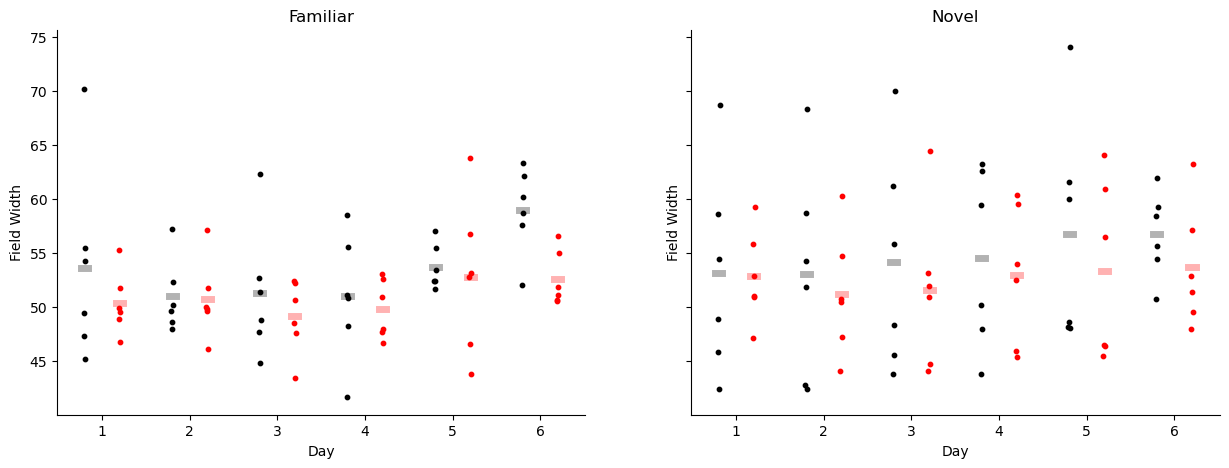

In [20]:
lw = 5
s = 10
fig, ax = plt.subplots(1,2, figsize=[15,5], sharey=True)

# population plots
for day in range(6):
    
    mask = (df['cond']=='ctrl') & (df['day']==day) & (df['ttype']=='fam')
    fw = 10.*df['field_width'].loc[mask]._values
    ax[0].scatter(5*day -1 + np.linspace(-0.05, 0.05, num=fw.shape[0]), fw, color='black', s=s)
    ax[0].plot(5*day -1 + np.array([-0.2, .2]), fw.mean()*np.ones([2,]), color='black', linewidth=lw,alpha = .3)
    
    mask = (df['cond']=='ctrl') & (df['day']==day) & (df['ttype']=='nov')
    fw = 10.*df['field_width'].loc[mask]._values
    ax[1].scatter(5*day -1 + np.linspace(-0.05, 0.05, num=fw.shape[0]), fw, color='black', s=s, alpha = 1)
    ax[1].plot(5*day -1 + np.array([-0.2, .2]), fw.mean()*np.ones([2,]), color='black', linewidth=lw,alpha = .3)
    
    mask = (df['cond']=='cre') & (df['day']==day) & (df['ttype']=='fam')
    fw = 10.*df['field_width'].loc[mask]._values
    ax[0].scatter(5*day +1 + np.linspace(-0.05, 0.05, num=fw.shape[0]), fw, color='red', s=s)
    ax[0].plot(5*day + 1 + np.array([-0.2, .2]), fw.mean()*np.ones([2,]), color='red', linewidth=lw,alpha = .3)
    
    mask = (df['cond']=='cre') & (df['day']==day) & (df['ttype']=='nov')
    fw = 10.*df['field_width'].loc[mask]._values
    ax[1].scatter(5*day +1 + np.linspace(-0.05, 0.05, num=fw.shape[0]), fw, color='red', s=s, alpha=1)
    ax[1].plot(5*day + 1 + np.array([-0.2, .2]), fw.mean()*np.ones([2,]), color='red', linewidth=lw,alpha = .3)
    

ax[0].set_title('Familiar')
ax[1].set_title('Novel')
    
for a in range(2):

    ax[a].set_xticks(np.arange(0,6*5,5))
    ax[a].set_xticklabels([x for x in range(1,7)])

    ax[a].spines['top'].set_visible(False)
    ax[a].spines['right'].set_visible(False)

    ax[a].set_ylabel('Field Width')
    ax[a].set_xlabel('Day')

# figdir = "C://Users/esay/data/Stx3/fig_scratch/behavior"
# fig.savefig(os.path.join(figdir, "field_width_across_mouse_summary.pdf"))

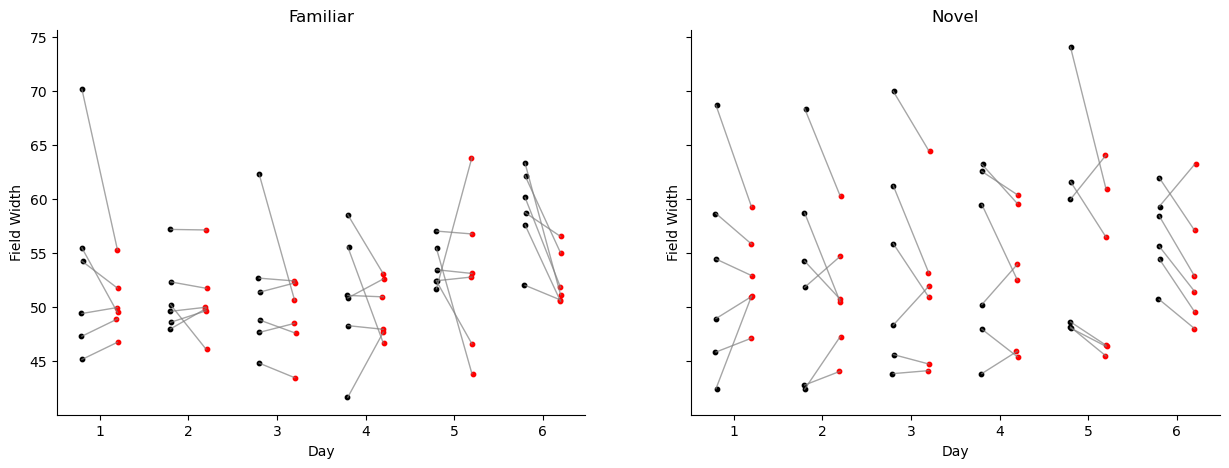

In [21]:
lw = 5
s = 10
fig, ax = plt.subplots(1, 2, figsize=[15, 5], sharey=True)
# Iterate through days
for day in range(6):
    # Plot ctrl fam (black) and cre fam (red) in Familiar
    mask_ctrl_fam = (df['cond'] == 'ctrl') & (df['day'] == day) & (df['ttype'] == 'fam')
    mask_cre_fam = (df['cond'] == 'cre') & (df['day'] == day) & (df['ttype'] == 'fam')
    # Extract mouse names and field widths
    ctrl_fam = df.loc[mask_ctrl_fam, ['mouse', 'field_width']].reset_index(drop=True)
    cre_fam = df.loc[mask_cre_fam, ['mouse', 'field_width']].reset_index(drop=True)
    # Plot black and red dots
    ax[0].scatter(5*day - 1 + np.linspace(-0.05, 0.05, num=len(ctrl_fam)), 10*ctrl_fam['field_width'], color='black', s=s)
    ax[0].scatter(5*day + 1 + np.linspace(-0.05, 0.05, num=len(cre_fam)), 10*cre_fam['field_width'], color='red', s=s)
    # Draw lines between matching mouse names
    for mouse in ctrl_fam['mouse']:
        if mouse in cre_fam['mouse'].values:
            y1 = 10 * ctrl_fam.loc[ctrl_fam['mouse'] == mouse, 'field_width'].values[0]
            y2 = 10 * cre_fam.loc[cre_fam['mouse'] == mouse, 'field_width'].values[0]
            ax[0].plot([5*day - 1, 5*day + 1], [y1, y2], color='gray', linestyle='-', linewidth=1, alpha=0.7)
    # Plot ctrl nov (black) and cre nov (red) in Novel
    mask_ctrl_nov = (df['cond'] == 'ctrl') & (df['day'] == day) & (df['ttype'] == 'nov')
    mask_cre_nov = (df['cond'] == 'cre') & (df['day'] == day) & (df['ttype'] == 'nov')
    ctrl_nov = df.loc[mask_ctrl_nov, ['mouse', 'field_width']].reset_index(drop=True)
    cre_nov = df.loc[mask_cre_nov, ['mouse', 'field_width']].reset_index(drop=True)
    ax[1].scatter(5*day - 1 + np.linspace(-0.05, 0.05, num=len(ctrl_nov)), 10*ctrl_nov['field_width'], color='black', s=s)
    ax[1].scatter(5*day + 1 + np.linspace(-0.05, 0.05, num=len(cre_nov)), 10*cre_nov['field_width'], color='red', s=s)
    # Draw lines between matching mouse names
    for mouse in ctrl_nov['mouse']:
        if mouse in cre_nov['mouse'].values:
            y1 = 10 * ctrl_nov.loc[ctrl_nov['mouse'] == mouse, 'field_width'].values[0]
            y2 = 10 * cre_nov.loc[cre_nov['mouse'] == mouse, 'field_width'].values[0]
            ax[1].plot([5*day - 1, 5*day + 1], [y1, y2], color='gray', linestyle='-', linewidth=1, alpha=0.7)
# Set titles and labels
ax[0].set_title('Familiar')
ax[1].set_title('Novel')
for a in range(2):
    ax[a].set_xticks(np.arange(0, 6*5, 5))
    ax[a].set_xticklabels([x for x in range(1, 7)])
    ax[a].spines['top'].set_visible(False)
    ax[a].spines['right'].set_visible(False)
    ax[a].set_ylabel('Field Width')
    ax[a].set_xlabel('Day')
# Save figure
# figdir = "C://Users/esay/data/Stx3/fig_scratch/behavior"
# fig.savefig(os.path.join(figdir, "field_width_across_mouse_summary_with_lines.pdf"))
# plt.show()

In [98]:
lr = [_df['field_width'].loc[_df['ttype']=='fam']._values, _df['field_width'].loc[_df['ttype']=='nov']._values]
lr

[array([], dtype=float64), array([], dtype=float64)]

0
SparseKO_10
SparseKO_11
SparseKO_13
SparseKO_10
SparseKO_11
SparseKO_13
1
SparseKO_10
SparseKO_11
SparseKO_13
SparseKO_10
SparseKO_11
SparseKO_13
2
SparseKO_10
SparseKO_11
SparseKO_13
SparseKO_10
SparseKO_11
SparseKO_13
3
SparseKO_10
SparseKO_11
SparseKO_13
SparseKO_10
SparseKO_11
SparseKO_13
4
SparseKO_10
SparseKO_11
SparseKO_13
SparseKO_10
SparseKO_11
SparseKO_13
5
SparseKO_10
SparseKO_11
SparseKO_13
SparseKO_10
SparseKO_11
SparseKO_13


Text(0.5, 0, 'Day')

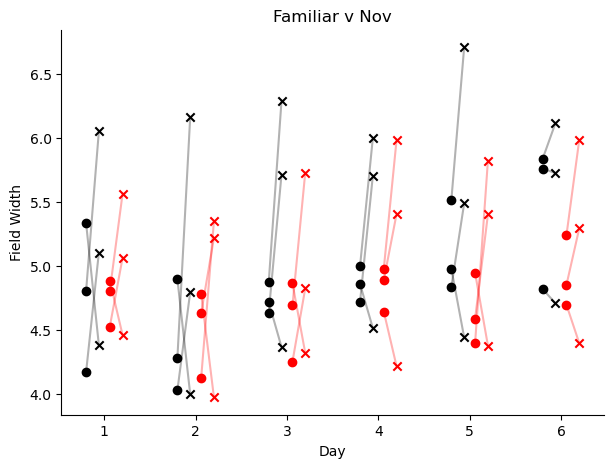

In [37]:
fig, ax = plt.subplots(figsize=[7,5], sharey=True)

lw = 5
s = 10
for day in range(6):
    print(day)
    mask = (df['cond']=='ctrl') & (df['day']==day) #& (df['fam/nov']=='fam')
    for mouse in sparse_mice[3:]:
        print(mouse)
        if day==2 and mouse=='SparseKO_09':
            continue
        
        _mask = mask & (df['mouse']==mouse)
        _df = df[_mask]
        lr = [_df['field_width'].loc[_df['ttype']=='fam']._values, _df['field_width'].loc[_df['ttype']=='nov']._values]
        
        ax.plot(5*day + np.array([-1,-.3]), lr, color='black', alpha = .3)
        # ax[0].scatter(5*day + np.array([-1,-.3]), lr, color='black', alpha = .3)
        ax.scatter(5*day - 1,lr[0], color='black', alpha = 1, marker='o')
        ax.scatter(5*day - .3, lr[1], color='black', alpha = 1, marker='x')
        
    mask = (df['cond']=='cre') & (df['day']==day) #& (df['fam/nov']=='fam')
    for mouse in sparse_mice[3:]:
        print(mouse)
        if day==2 and mouse=='SparseKO_09':
            continue
            
        _mask = mask & (df['mouse']==mouse)
        _df = df[_mask]
        lr = [_df['field_width'].loc[_df['ttype']=='fam']._values, _df['field_width'].loc[_df['ttype']=='nov']._values]
        
        ax.plot(5*day + np.array([.3,1]), lr, color='red', alpha = .3)
        ax.scatter(5*day + .3,lr[0], color='red', alpha = 1, marker='o')
        ax.scatter(5*day + 1, lr[1], color='red', alpha = 1, marker='x')

    
# ax.plot([-2.3, 27.3], [0, 0], 'k--', zorder= -1, alpha=.5)

    
ax.set_title('Familiar v Nov')

ax.set_xticks(np.arange(0,6*5,5))
ax.set_xticklabels([x for x in range(1,7)])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_ylabel('Field Width')
ax.set_xlabel('Day')

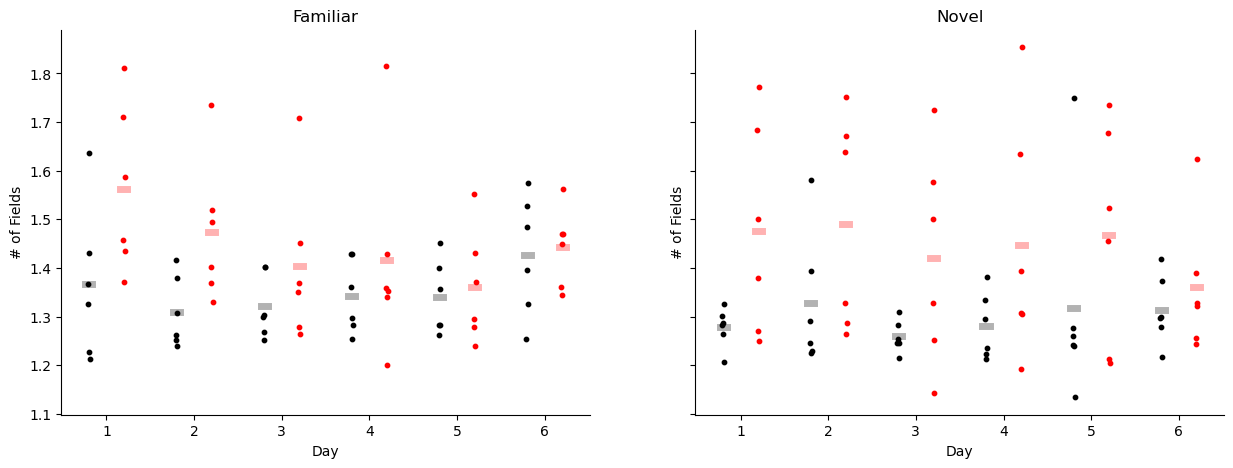

In [22]:
fig, ax = plt.subplots(1,2, figsize=[15,5], sharey=True)

# population plots
for day in range(6):
    
    mask = (df['cond']=='ctrl') & (df['day']==day) & (df['ttype']=='fam')
    nf = df['n_fields'].loc[mask]._values
    ax[0].scatter(5*day -1 + np.linspace(-0.05, 0.05, num=nf.shape[0]), nf, color='black', s=s)
    ax[0].plot(5*day -1 + np.array([-0.2, .2]), nf.mean()*np.ones([2,]), color='black', linewidth=lw,alpha = .3)
    
    mask = (df['cond']=='ctrl') & (df['day']==day) & (df['ttype']=='nov')
    nf = df['n_fields'].loc[mask]._values
    ax[1].scatter(5*day -1 + np.linspace(-0.05, 0.05, num=nf.shape[0]), nf, color='black', s=s, alpha = 1)
    ax[1].plot(5*day -1 + np.array([-0.2, .2]), nf.mean()*np.ones([2,]), color='black', linewidth=lw,alpha = .3)
    
    mask = (df['cond']=='cre') & (df['day']==day) & (df['ttype']=='fam')
    nf = df['n_fields'].loc[mask]._values
    ax[0].scatter(5*day +1 + np.linspace(-0.05, 0.05, num=nf.shape[0]), nf, color='red', s=s)
    ax[0].plot(5*day + 1 + np.array([-0.2, .2]), nf.mean()*np.ones([2,]), color='red', linewidth=lw,alpha = .3)
    
    mask = (df['cond']=='cre') & (df['day']==day) & (df['ttype']=='nov')
    nf = df['n_fields'].loc[mask]._values
    ax[1].scatter(5*day +1 + np.linspace(-0.05, 0.05, num=nf.shape[0]), nf, color='red', s=s, alpha=1)
    ax[1].plot(5*day + 1 + np.array([-0.2, .2]), nf.mean()*np.ones([2,]), color='red', linewidth=lw,alpha = .3)

ax[0].set_title('Familiar')
ax[1].set_title('Novel')
    
for a in range(2):

    ax[a].set_xticks(np.arange(0,6*5,5))
    ax[a].set_xticklabels([x for x in range(1,7)])

    ax[a].spines['top'].set_visible(False)
    ax[a].spines['right'].set_visible(False)

    ax[a].set_ylabel('# of Fields')
    ax[a].set_xlabel('Day')
# fig.savefig(os.path.join(figdir, "num_fields_across_mouse_summary.pdf"))


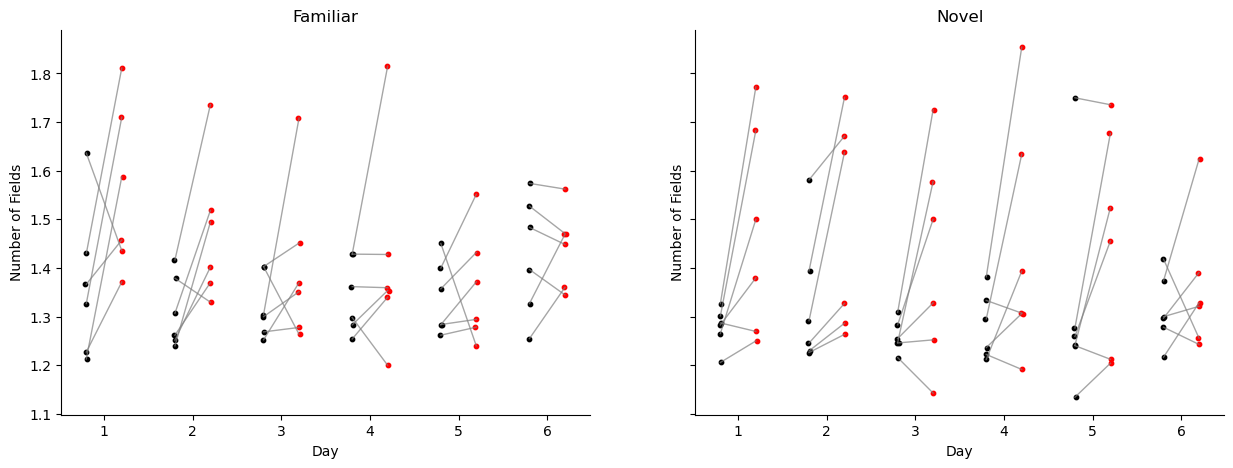

In [23]:
lw = 5
s = 10
fig, ax = plt.subplots(1, 2, figsize=[15, 5], sharey=True)
for day in range(6):
    # Plot ctrl fam (black) and cre fam (red) in Familiar
    mask_ctrl_fam = (df['cond'] == 'ctrl') & (df['day'] == day) & (df['ttype'] == 'fam')
    mask_cre_fam = (df['cond'] == 'cre') & (df['day'] == day) & (df['ttype'] == 'fam')
    # Extract mouse names and field widths
    ctrl_fam = df.loc[mask_ctrl_fam, ['mouse', 'n_fields']].reset_index(drop=True)
    cre_fam = df.loc[mask_cre_fam, ['mouse', 'n_fields']].reset_index(drop=True)
    # Plot black and red dots
    ax[0].scatter(5*day - 1 + np.linspace(-0.05, 0.05, num=len(ctrl_fam)), ctrl_fam['n_fields'], color='black', s=s)
    ax[0].scatter(5*day + 1 + np.linspace(-0.05, 0.05, num=len(cre_fam)), cre_fam['n_fields'], color='red', s=s)
    # Draw lines between matching mouse names
    for mouse in ctrl_fam['mouse']:
        if mouse in cre_fam['mouse'].values:
            y1 = ctrl_fam.loc[ctrl_fam['mouse'] == mouse, 'n_fields'].values[0]
            y2 = cre_fam.loc[cre_fam['mouse'] == mouse, 'n_fields'].values[0]
            ax[0].plot([5*day - 1, 5*day + 1], [y1, y2], color='gray', linestyle='-', linewidth=1, alpha=0.7)
    # Plot ctrl nov (black) and cre nov (red) in Novel
    mask_ctrl_nov = (df['cond'] == 'ctrl') & (df['day'] == day) & (df['ttype'] == 'nov')
    mask_cre_nov = (df['cond'] == 'cre') & (df['day'] == day) & (df['ttype'] == 'nov')
    ctrl_nov = df.loc[mask_ctrl_nov, ['mouse', 'n_fields']].reset_index(drop=True)
    cre_nov = df.loc[mask_cre_nov, ['mouse', 'n_fields']].reset_index(drop=True)
    ax[1].scatter(5*day - 1 + np.linspace(-0.05, 0.05, num=len(ctrl_nov)), ctrl_nov['n_fields'], color='black', s=s)
    ax[1].scatter(5*day + 1 + np.linspace(-0.05, 0.05, num=len(cre_nov)), cre_nov['n_fields'], color='red', s=s)
    # Draw lines between matching mouse names
    for mouse in ctrl_nov['mouse']:
        if mouse in cre_nov['mouse'].values:
            y1 = ctrl_nov.loc[ctrl_nov['mouse'] == mouse, 'n_fields'].values[0]
            y2 = cre_nov.loc[cre_nov['mouse'] == mouse, 'n_fields'].values[0]
            ax[1].plot([5*day - 1, 5*day + 1], [y1, y2], color='gray', linestyle='-', linewidth=1, alpha=0.7)
# Set titles and labels
ax[0].set_title('Familiar')
ax[1].set_title('Novel')
for a in range(2):
    ax[a].set_xticks(np.arange(0, 6*5, 5))
    ax[a].set_xticklabels([x for x in range(1, 7)])
    ax[a].spines['top'].set_visible(False)
    ax[a].spines['right'].set_visible(False)
    ax[a].set_ylabel('Number of Fields')
    ax[a].set_xlabel('Day')

plt.show()

In [24]:
for mouse, days in trial_means.items():
    for day, metrics in days.items():
        for key in list(metrics.keys()):
            if "nov_mean" in key:
                metrics[key.replace("nov_mean","left")] = metrics.pop(key)
            elif "fam_mean" in key:
                metrics[key.replace("fam_mean","right")] = metrics.pop(key)

In [25]:
field_info.keys()

dict_keys(['SparseKO_06', 'SparseKO_08', 'SparseKO_10', 'SparseKO_11', 'SparseKO_13', 'SparseKO_02'])

In [26]:
nov_df = df[df['ttype'] == 'nov']
fam_df = df[df['ttype'] == 'fam']
fam_df, nov_df

(           mouse  cond ttype  day  field_width  n_fields
 1    SparseKO_02   cre   fam    0     4.891139  1.457565
 3    SparseKO_02  ctrl   fam    0     4.731707  1.366667
 5    SparseKO_02   cre   fam    1     5.000000  1.369942
 7    SparseKO_02  ctrl   fam    1     4.962264  1.261905
 9    SparseKO_02   cre   fam    2     5.243333  1.351351
 ..           ...   ...   ...  ...          ...       ...
 135  SparseKO_13  ctrl   fam    3     5.558824  1.283019
 137  SparseKO_13   cre   fam    4     4.385417  1.371429
 139  SparseKO_13  ctrl   fam    4     5.545455  1.283333
 141  SparseKO_13   cre   fam    5     5.504202  1.469136
 143  SparseKO_13  ctrl   fam    5     6.217391  1.326923
 
 [72 rows x 6 columns],
            mouse  cond ttype  day  field_width  n_fields
 0    SparseKO_02   cre   nov    0     4.713389  1.683099
 2    SparseKO_02  ctrl   nov    0     4.585366  1.301587
 4    SparseKO_02   cre   nov    1     4.407018  1.637931
 6    SparseKO_02  ctrl   nov    1     4.27957

In [27]:
pg.rm_anova(data=nov_df, dv='field_width', within='cond', subject='mouse', correction='auto', detailed=False, effsize='ng2')


,Source,ddof1,ddof2,F,p-unc,ng2,eps
0,cond,1,5,3.723199,0.111553,0.026039,1.0


In [28]:
pg.rm_anova(data=fam_df, dv='field_width', within='cond', subject='mouse', correction='auto', detailed=True, effsize='ng2')


,Source,SS,DF,MS,F,p-unc,ng2,eps
0,cond,0.165798,1,0.165798,2.650487,0.164447,0.121488,1.0
1,Error,0.312769,5,0.062554,NaN,NaN,NaN,NaN


In [29]:
pg.rm_anova(data=nov_df, dv='n_fields', within='cond', subject='mouse', correction='auto', detailed=True, effsize='ng2')


,Source,SS,DF,MS,F,p-unc,ng2,eps
0,cond,0.065421,1,0.065421,6.324725,0.053507,0.225139,1.0
1,Error,0.051719,5,0.010344,NaN,NaN,NaN,NaN


In [30]:
pg.rm_anova(data=fam_df, dv='n_fields', within='cond', subject='mouse', correction='auto', detailed=True, effsize='ng2')


,Source,SS,DF,MS,F,p-unc,ng2,eps
0,cond,0.025573,1,0.025573,6.731596,0.04857,0.22217,1.0
1,Error,0.018995,5,0.003799,NaN,NaN,NaN,NaN
